# Star wars characters network analysis

Final project for 02805 Social Graphs And Interactions course.

Authors:

* Emilia Konopko
* Barbara Piekarska
* Aleksander Nagaj

## Prepare environment

In [58]:
# standard library
import os
import pickle
import random

# related third-party
import fa2
from matplotlib import (
    cm,
    colors,
)
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
from PIL import Image
import seaborn as sns
from wordcloud import WordCloud

# Local
from datautils import datautils
from graph import graph
from sentiment import sentiment
from style import style

base_graph_dir = "graph/"
FA_POSITIONS_ALL = base_graph_dir + "fa_positions_all.pickle"
UNIVERSE_EDGELIST_PATH = base_graph_dir + "universe.edgelist"
GRAPH_UNIVERSE_PATH = base_graph_dir + "universe.pickle"
GRAPH_EPISODES_PATH = base_graph_dir + "universe_episodes.pickle"
FA_POSITIONS_EPISODES = base_graph_dir + "fa_positions_ep.pickle"

### Data loading

In [29]:
loader = datautils.Loader()
loader.load("data/characters/")
data = loader.to_dataframe()
loader.drop()

## Main Network

Network containing all characters, regardless whether they originated from movie, comic, canon or purely fandom creations.

### Creating graphs

* Directed Graph,
* Directed Largest Connected Components Graph
* Undirected Largest Connected Components Graph

In [30]:
if os.path.exists(GRAPH_UNIVERSE_PATH):
    with open(GRAPH_UNIVERSE_PATH, 'rb') as f:
        universe = pickle.load(f)
else:
    universe = graph.create_directed_graph(data)
    # save graph as an edgelist
    nx.write_edgelist(universe, UNIVERSE_EDGELIST_PATH)

    with open(GRAPH_UNIVERSE_PATH, 'wb') as f:
        pickle.dump(universe, f)

In [31]:
style.print_header("Directed graph")
print(f"Number of nodes: {len(universe.nodes)}")
print(f"Number of links: {len(universe.edges)}")
print()

universe_cc = graph.connected_components(universe)
style.print_header("Large Connected Components directed graph")
print(f"Number of nodes: {len(universe_cc.nodes)}")
print(f"Number of links: {len(universe_cc.edges)}")
print()

universe_cc_undirected = universe_cc.to_undirected()
style.print_header("Large Connected Components undirected graph")
print(f"Number of nodes: {len(universe_cc_undirected)}")
print(f"Number of links: {len(universe_cc_undirected.edges)}")

==================== Directed graph ====================

Number of nodes: 29435
Number of links: 91957

==================== Large Connected Components directed graph ====================

Number of nodes: 19080
Number of links: 86586

==================== Large Connected Components undirected graph ====================

Number of nodes: 19080
Number of links: 62704


> For further analysis only Largest Connected Component (LCC) will be used

### Degree distribution

==================== Universe stats ====================

In degree: {'mean': 4.5380503144654085, 'median': 2.0, 'mode': 1, 'min': 0, 'max': 915}
Out degree: {'mean': 4.5380503144654085, 'median': 3.0, 'mode': 1, 'min': 0, 'max': 390}

Calculating best minimal value for power law fit
In degree slope: 2.55


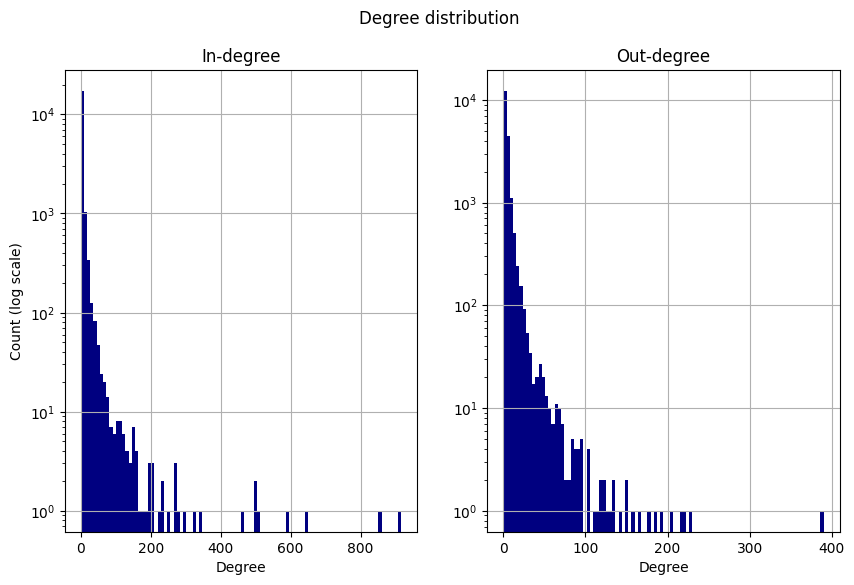

In [32]:
# calculater degree distributions
style.print_header("Universe stats")
in_stats = graph.calc_stats(universe_cc.in_degree())
out_stats = graph.calc_stats(universe_cc.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

print()
print(f"In degree slope: {graph.power_law_fit(universe_cc):.2f}")    

in_degree, out_degree = graph.plot_degree_distribution(universe_cc, scale='log')

### Largest Connected Component Visualization

Undirected version of graph was used.

[]

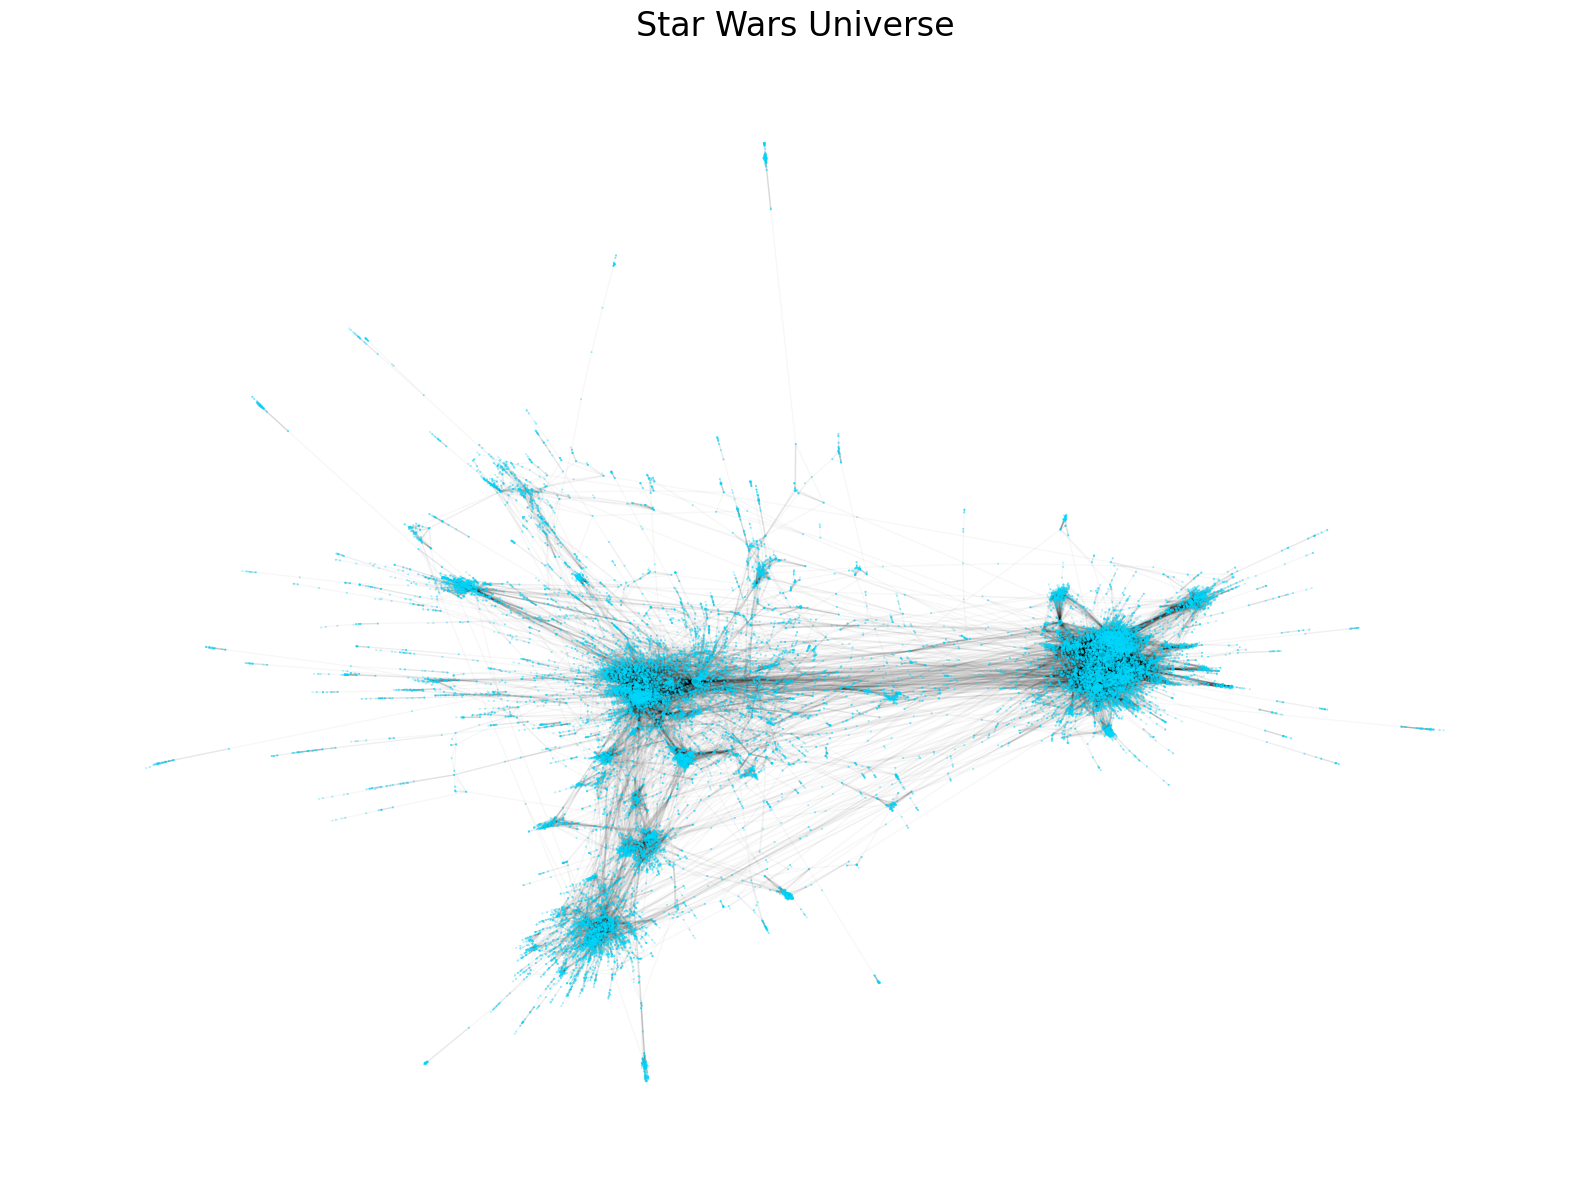

In [33]:
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS_ALL):
    with open(FA_POSITIONS_ALL, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2(
        verbose=False,
    ).forceatlas2_networkx_layout(
        universe_cc_undirected,
        pos=None,
        iterations=2000,
    )
    # save to pickle for later use
    with open(FA_POSITIONS_ALL, "wb") as wbfile:
        pickle.dump(positions, wbfile)

_ = graph.plot_graph_with_positons(
    universe_cc_undirected,
    positions,
    "Star Wars Universe",
    node_alpha=0.8,
    node_size_factor=0.03,
    edge_alpha=0.03,
    figsize=style.LARGE_FIGSIZE,
)
plt.plot()

### Largest hubs

In [34]:
style.print_header("Characters with the largest number of in degree")
print("{:<4s}{:30s}{}".format("no.", "Character", "In degree"))

in_degree_sorted = np.argsort(in_degree)[::-1]
nodes_list = list(universe_cc.nodes())
for i in range(10):
    character = nodes_list[in_degree_sorted[i]]
    degree = universe_cc.in_degree(character)
    print(f"{i+1:<4d}{data[data.Name == character].DisplayName.values[0]:30s}{degree}")

print()
style.print_header("Characters with the largest number of out degree")
print("{:<4s}{:30s}{}".format("no.", "Character", "Out degree"))

out_degree_sorted = np.argsort(out_degree)[::-1]
for i in range(10):
    character = nodes_list[out_degree_sorted[i]] 
    degree = universe_cc.out_degree(character)
    print(f"{i+1:<4d}{data[data.Name == character].DisplayName.values[0]:30s}{degree}")

==================== Characters with the largest number of in degree ====================

no. Character                     In degree
1   Anakin Skywalker              915
2   Leia Organa Solo              852
3   Darth Sidious                 648
4   Ruwan Tokai                   590
5   Han Solo                      506
6   Obi-Wan Kenobi                501
7   Leia Skywalker Organa Solo    496
8   Luke Skywalker                461
9   Ahsoka Tano                   340
10  Chewbacca                     327

==================== Characters with the largest number of out degree ====================

no. Character                     Out degree
1   Anakin Skywalker              390
2   Obi-Wan Kenobi                229
3   Leia Skywalker Organa Solo    222
4   Darth Caedus                  218
5   Ahsoka Tano                   204
6   Corran Horn                   194
7   Jaina Solo Fel                186
8   Mitth'raw'nuruodo             178
9   Han Solo                      164
10  L

Wookiepedia contains two pages for princess Leia character. It was decided to proceed with analysis with both of them, because both articles are rich in content.

1. [Leia Skywalker Organa Solo](https://starwars.fandom.com/wiki/Leia_Skywalker_Organa_Solo?so=search)
2. [Leia Organa Solo](https://starwars.fandom.com/wiki/Leia_Organa_Solo)

In [35]:
# Leia character is repeated in the data
data[data.Name.isin(["Leia_Skywalker_Organa_Solo", "Leia_Organa_Solo"])]

Name                 DisplayName  \
13420            Leia_Organa_Solo            Leia Organa Solo   
13421  Leia_Skywalker_Organa_Solo  Leia Skywalker Organa Solo   

                                                 Content  \
13420  Leia Organa Solo , a Force-sensitive Human fem...   
13421  Leia Skywalker Organa Solo was a Force-sensiti...   

                                              Crosslinks Species  Gender  \
13420  [Star_Wars_Legends, Wookieepedia:Featured_arti...   Human  Female   
13421  [Canon, Leia_Skywalker_Organa_Solo, Leia_Organ...   Human  Female   

                                          Affiliation(s) Homeworld  \
13420  [Galactic Empire, House Organa, Alderaanian Re...  Alderaan   
13421  [Skywalker family, Elder Houses, House of Orga...  Alderaan   

                                 Died  
13420  [0 ABY, Bedlam, 2 ABY, Mimban]  
13421            [35 ABY, Ajan Kloss]

### Finding communities in the universe

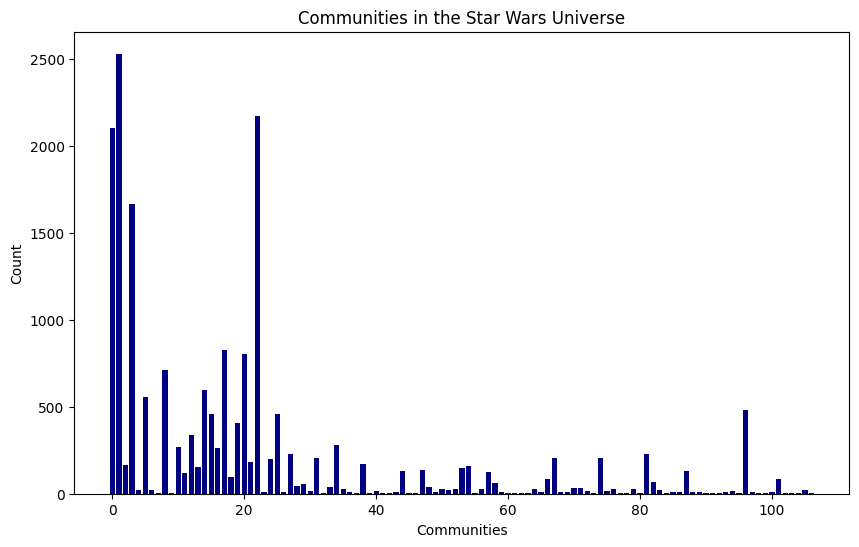

In [36]:
partition, communities, mod = graph.find_communities(universe_cc_undirected)
graph.plot_distribution(
    communities.keys(),
    communities.values(),
    title="Communities in the Star Wars Universe",
    xlabel="Communities",
)

In [37]:
# separate only communities with the size larger than 500 to color them
biggest_communities = []

for key, val in communities.items():
    if val > 500:
        biggest_communities.append(key)

biggest_communities_node = dict()
for key, val in partition.items():
    if val in biggest_communities:
        biggest_communities_node[key] = val

data_biggest_communities = data.loc[data['Name'].isin(biggest_communities_node.keys())].reset_index(drop=True)

partition_biggest_communities = []
for n in data_biggest_communities.Name:
    partition_biggest_communities.append(biggest_communities_node[n])

In [38]:
sns_colors = sns.color_palette("tab10").as_hex()

colors_dict = dict()
for i, c in enumerate(biggest_communities):
    colors_dict[c] = sns_colors[i]

color_map = []

for i in partition.values():
    if i in biggest_communities:
        color_map.append(colors_dict[i])
    else:
        color_map.append('lightgrey')

Visualization of the universe with coloring of communities having more than 500 members/

<AxesSubplot: title={'center': 'Star Wars Communities'}>

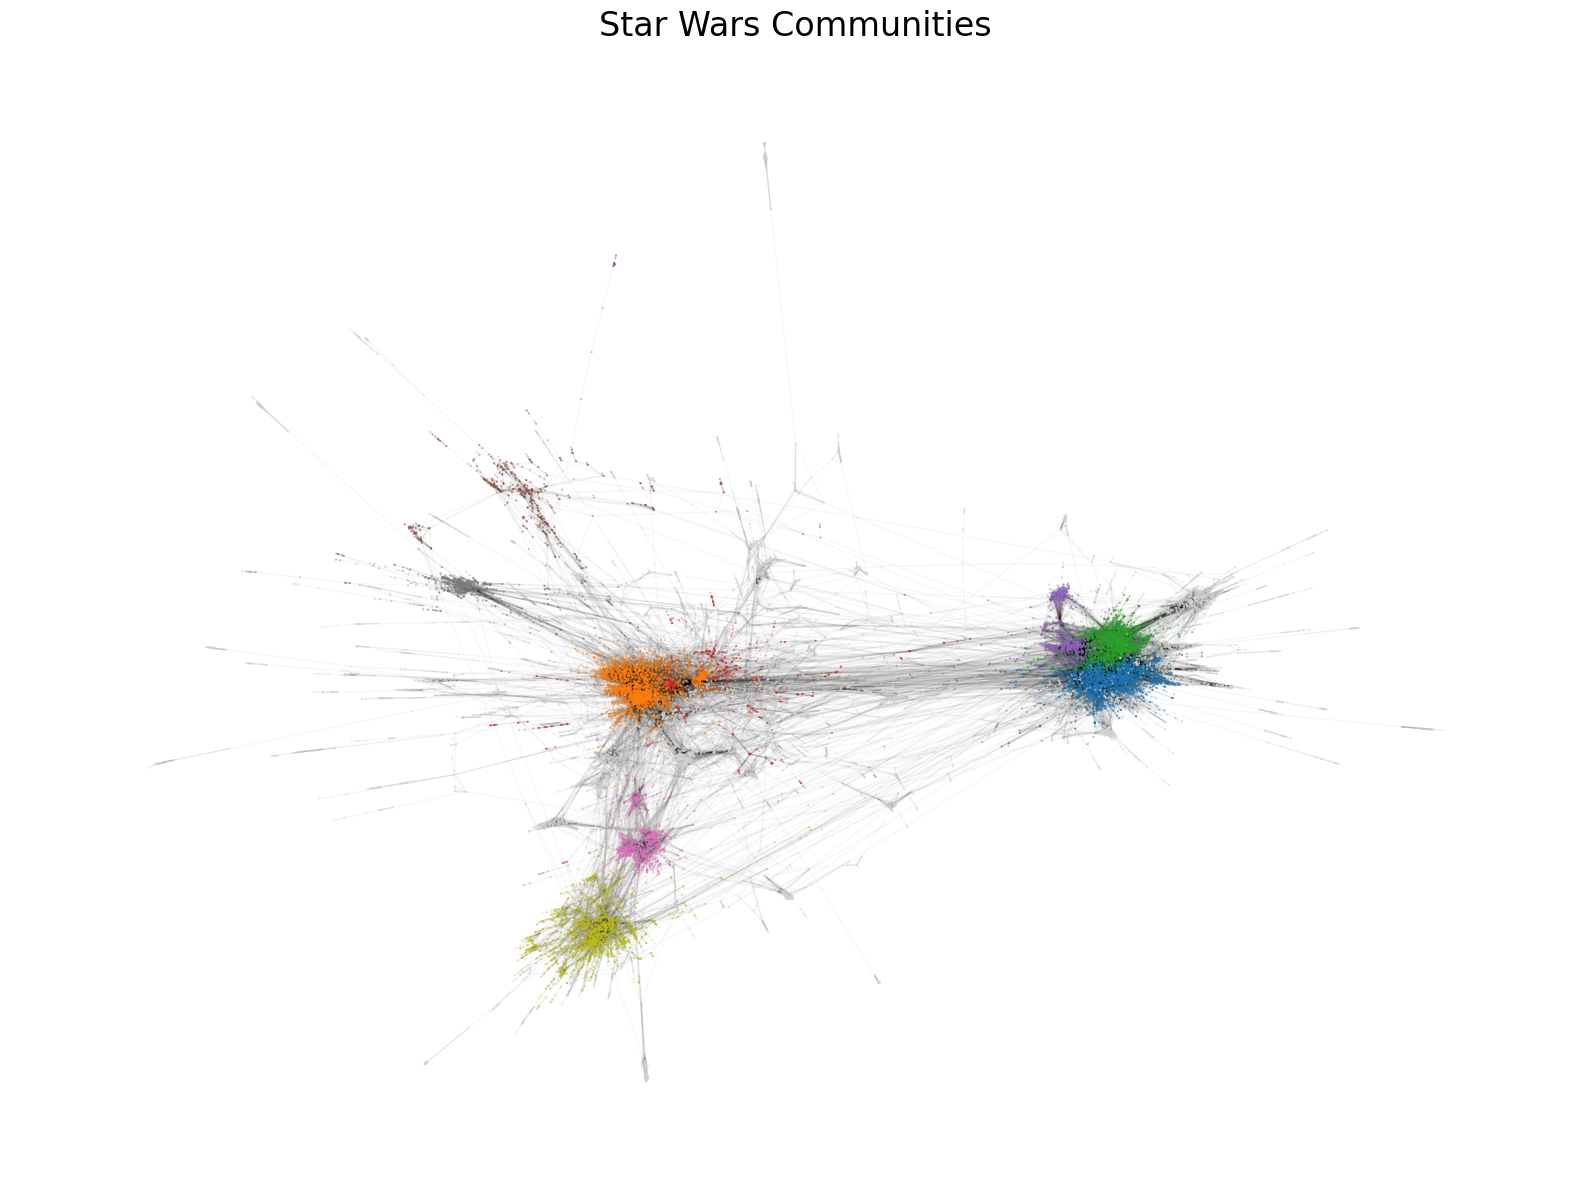

In [39]:
node_degrees = sorted(universe_cc_undirected.degree, key=lambda x: x[1], reverse=True)

graph.plot_graph_with_positons(
    universe_cc_undirected,
    positions,
    "Star Wars Communities",
    node_color=color_map,
    node_alpha=0.8,
    node_size_factor=0.03,
    edge_alpha=0.03,
    figsize=style.LARGE_FIGSIZE,
)

## Outlier analysis

In [40]:
outliers = [node for node in universe.nodes() if universe.degree(node) == 0]
print(f"There are {len(outliers)} nodes without any edges, which were defined as outliers.")

There are 6462 nodes without any edges, which were defined as outliers.


In [41]:
outliers_data = data.loc[data['Name'].isin(outliers)]
outliers_data.head()

Name          DisplayName  \
0   %22Blue%22_Imcrix        "Blue" Imcrix   
1  %22Fugitive%22_Fod       "Fugitive" Fod   
3  %27Ndranth_Poussan     'Ndranth Poussan   
4                0761                 0761   
7  1138_(First_Order)  1138  (First Order)   

                                             Content  \
0  "Blue" Imcrix was an infamous male Taloron cri...   
1  "Fugitive" Fod was a male Yuzzum from Endor wh...   
3  'Ndranth Poussan was a Human male starfighter ...   
4  0761 was a stormtrooper who was stationed on C...   
7  1138 was a human male stormtrooper who served ...   

                                          Crosslinks  Species Gender  \
0  [Star_Wars_Legends, Taloron, Gender/Legends, C...  Taloron   Male   
1  [Star_Wars_Legends, Endor/Legends, Yuzzum/Lege...   Yuzzum   Male   
3  [Star_Wars_Legends, Wookieepedia:Good_articles...    Human   Male   
4  [Star_Wars_Legends, 5_ABY/Legends, Ciutric_IV,...    Human   Male   
7  [Canon, 1138, Special:Upload, Human, Gender, F...    Human   Male   

                                      Affiliation(s) Homeworld  \
0                                                NaN       NaN   
1                                                NaN     Endor   
3  [Agamar Resistance, Alliance to Restore the Re...    Agamar   
4  [Galactic EmpireStormtrooper Corps, Stormtroop...       NaN   
7  [First Order, Stormtrooper Corps, Stormtrooper...       NaN   

                   Died  
0                   NaN  
1                   NaN  
3  [1 BBY, near Brigia]  
4   [5 ABY, Ciutric IV]  
7                   NaN

Most of the outliers are linked with "Legends" articles.

In [42]:
outliers_data["Crosslinks"].explode().value_counts()

Star_Wars_Legends              5850
Gender/Legends                 5306
Human/Legends                  2855
Color/Legends                  2334
Wookieepedia:Stub              2176
                               ... 
Hammer_Station                    1
Battle_station                    1
Mechanical_Liberation_Front       1
MerenData/Legends                 1
Challenge_37                      1
Name: Crosslinks, Length: 16883, dtype: int64

Most of the outliers are either members of Republic or Empire. Which may indicate that these are generic characters, such as stormtroopers or soldiers, who had their little episode. Not necessairly meainingful.

In [43]:
outliers_data["Affiliation(s)"].dropna().explode().value_counts()

Galactic Republic                    622
Sith Empire                          487
Galactic Empire                      471
Alliance to Restore the Republic     301
Jedi Order                           269
                                    ... 
Edan Spaceways                         1
Corellian Shipbuilders Union           1
Galactic EmpireMoff Lasre Dardano      1
Moff Lasre Dardano                     1
Rebel AllianceArdan resistance         1
Name: Affiliation(s), Length: 1476, dtype: int64

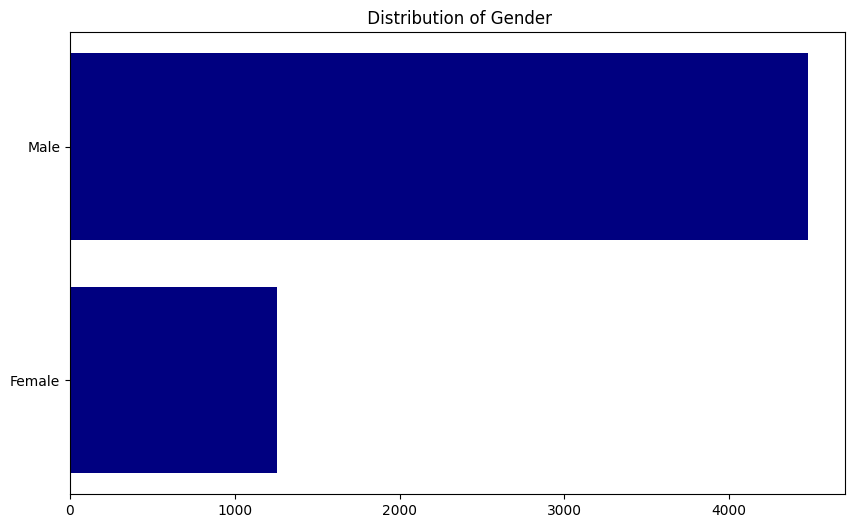

In [44]:
# TODO: add conclusions
datautils.plot_series_distribution(outliers_data["Gender"], 2)

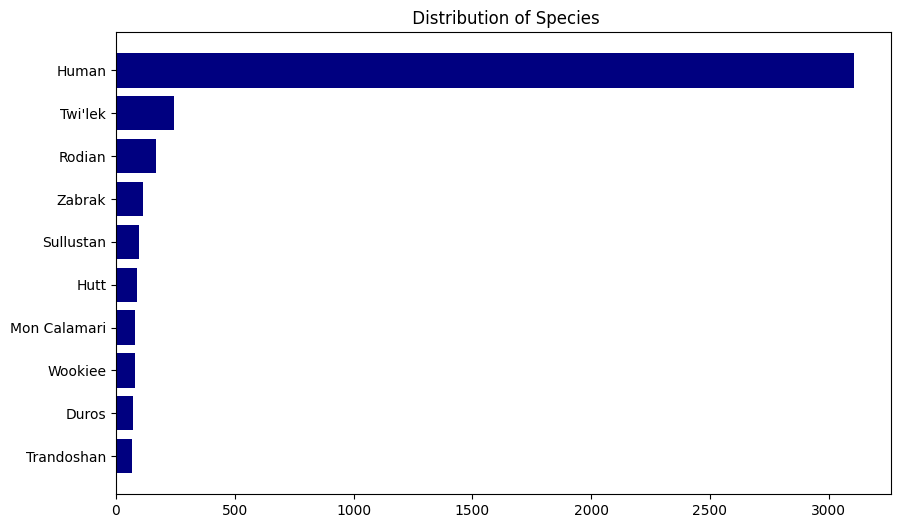

In [45]:
# TODO: add conclusions
datautils.plot_series_distribution(outliers_data["Species"])

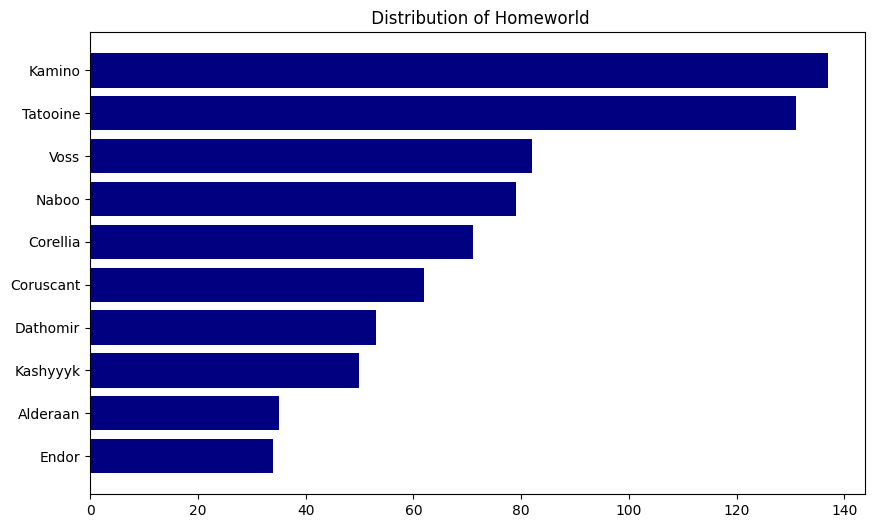

In [46]:
# TODO: add conclusions
datautils.plot_series_distribution(outliers_data["Homeworld"].dropna().astype(str))

## Analysis of universe based on canonical movies

In [47]:
episodes = [
    "Star_Wars:_Episode_I_The_Phantom_Menace",
    "Star_Wars:_Episode_II_Attack_of_the_Clones",
    "Star_Wars:_Episode_III_Revenge_of_the_Sith",
    "Star_Wars:_Episode_IV_A_New_Hope",
    "Star_Wars:_Episode_V_The_Empire_Strikes_Back",
    "Star_Wars:_Episode_VI_Return_of_the_Jedi",
    "Star_Wars:_Episode_VII_The_Force_Awakens",
    "Star_Wars:_Episode_VIII_The_Last_Jedi",
    "Star_Wars:_Episode_IX_The_Rise_of_Skywalker",
]

characters_in_episodes = []

for _, char in data.iterrows():
    # iterate over records
    for crosslink in char.Crosslinks:
        if crosslink in episodes:
            # append only characters which have crosslink to one of the episodes
            characters_in_episodes.append(char.Name)
            break

episodes_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
episodes_characters_data.head()

Name          DisplayName  \
5                 1047                 1047   
7   1138_(First_Order)  1138  (First Order)   
28               4/163                4/163   
30               5/373                5/373   
32               6/298                6/298   

                                              Content  \
5   1047 was a Human male stormtrooper who served ...   
7   1138 was a human male stormtrooper who served ...   
28  CT-4/163 was a clone trooper in the Grand Army...   
30  5/373 was a clone trooper in the Grand Army of...   
32  6/298 was a clone trooper in the Grand Army of...   

                                           Crosslinks Species Gender  \
5   [Star_Wars_Legends, Wookieepedia:Good_articles...   Human   Male   
7   [Canon, 1138, Special:Upload, Human, Gender, F...   Human   Male   
28  [Star_Wars_Legends, Kamino/Legends, Human/Lege...   Human   Male   
30  [Star_Wars_Legends, Wookieepedia:Sourcing, Spe...   Human   Male   
32  [Star_Wars_Legends, Kamino/Legends, 32_BBY/Leg...   Human   Male   

                                       Affiliation(s) Homeworld Died  
5     [Galactic Empire, Zeta Squadron, Zeta Squadron]       NaN  NaN  
7   [First Order, Stormtrooper Corps, Stormtrooper...       NaN  NaN  
28  [Galactic Republic, Grand Army of the Republic...    Kamino  NaN  
30  [Galactic RepublicGrand Army of the Republic, ...    Kamino  NaN  
32  [Galactic Republic, Grand Army of the Republic...    Kamino  NaN

In [48]:
if os.path.exists(GRAPH_EPISODES_PATH):
    with open(GRAPH_EPISODES_PATH, 'rb') as f:
        universe_episodes = pickle.load(f)
else:
    universe_episodes = graph.create_directed_graph(episodes_characters_data)

    with open(GRAPH_EPISODES_PATH, 'wb') as f:
        pickle.dump(universe_episodes, f)

==================== Universe stats ====================

In degree: {'mean': 4.605247641509434, 'median': 1.0, 'mode': 0, 'min': 0, 'max': 450}
Out degree: {'mean': 4.605247641509434, 'median': 2.0, 'mode': 0, 'min': 0, 'max': 190}
Number of nodes: 3392
Number of edges: 15621
==================== Largest connected component stats ====================

Number of nodes: 2276
Number of edges: 10438


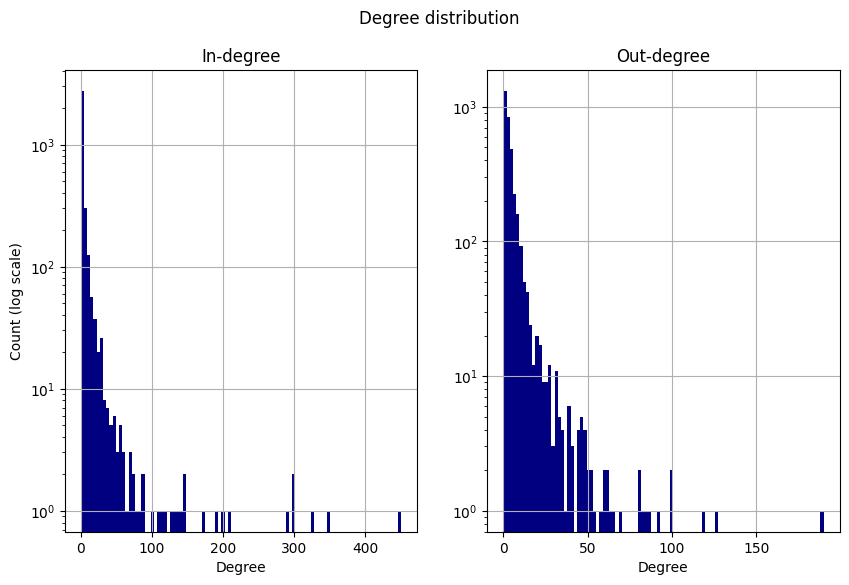

In [49]:
style.print_header("Universe stats")
print(f"In degree: {graph.calc_stats(universe_episodes.in_degree())}")
print(f"Out degree: {graph.calc_stats(universe_episodes.out_degree())}")
print(f"Number of nodes: {len(universe_episodes.nodes)}")
print(f"Number of edges: {len(universe_episodes.edges)}")
_ = graph.plot_degree_distribution(universe_episodes, scale="log")

# Get the largest connected component and transform to undirected graph
universe_episodes = graph.connected_components(universe_episodes)
universe_episodes = universe_episodes.to_undirected()

style.print_header("Largest connected component stats")
print(f"Number of nodes: {len(universe_episodes.nodes)}")
print(f"Number of edges: {len(universe_episodes.edges)}")

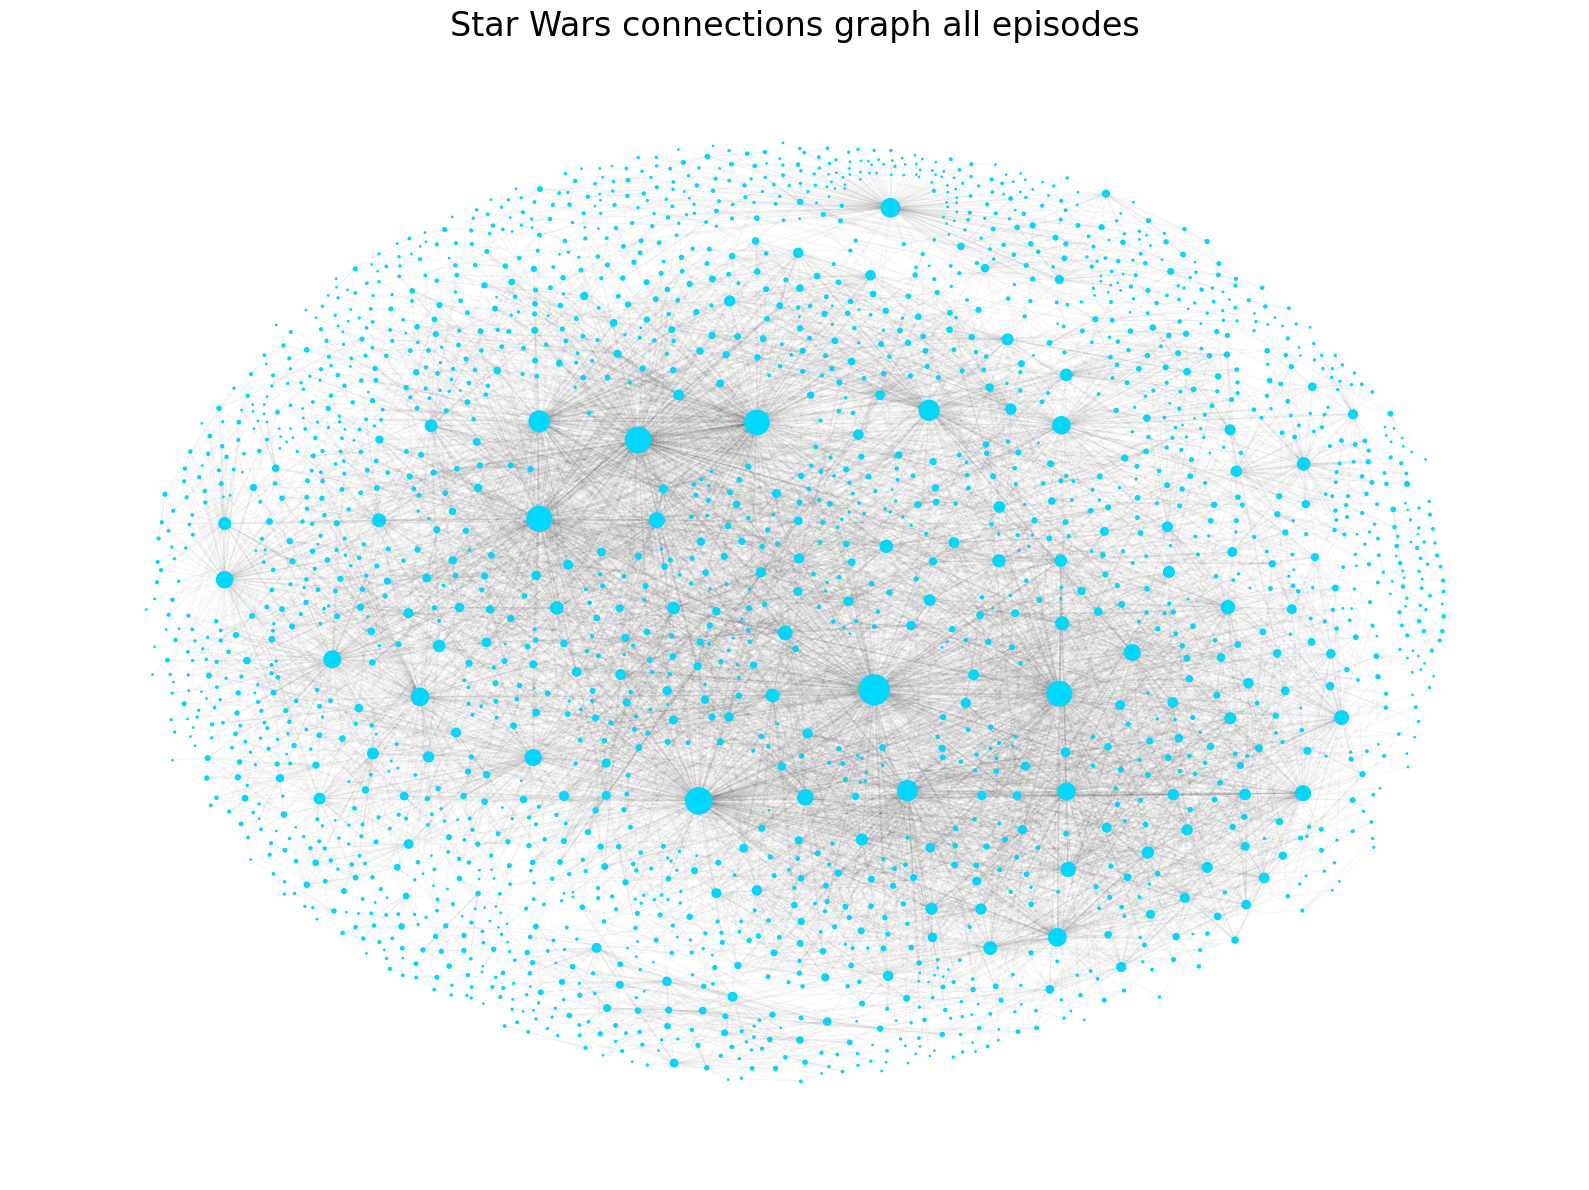

In [50]:
# use Force Atlas 2
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS_EPISODES):
    with open(FA_POSITIONS_EPISODES, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2(strongGravityMode=True).forceatlas2_networkx_layout(universe_episodes, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS_EPISODES, "wb") as wbfile:
        pickle.dump(positions, wbfile)

_ = graph.plot_graph_with_positons(
    universe_episodes,
    positions,
    "Star Wars connections graph all episodes",
    node_alpha=1,
    edge_alpha=0.033,
    figsize=style.LARGE_FIGSIZE,
)
plt.show()

### Finding communities

Graph modularity 0.56


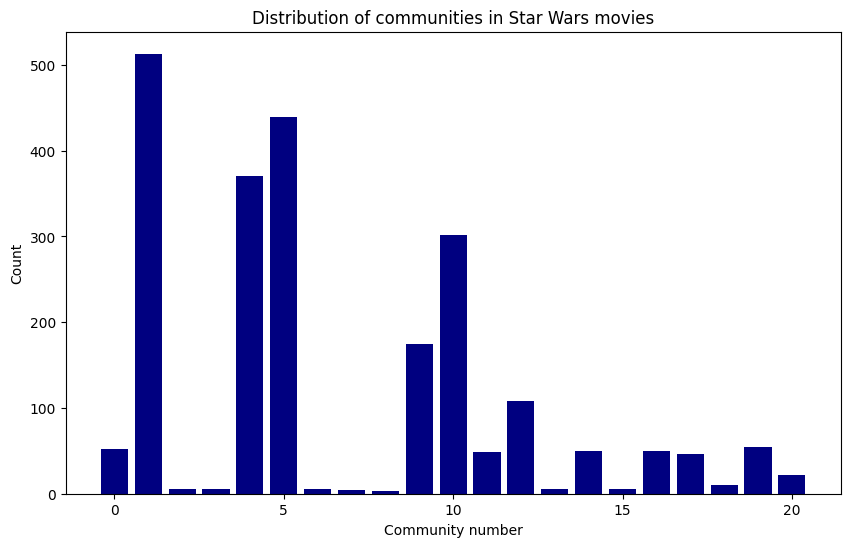

In [51]:
# find communities and its properties
partition, communities, mod = graph.find_communities(universe_episodes)
most_comm_communities = communities.most_common(10)
print(f"Graph modularity {mod:.2f}")
graph.plot_distribution(
    communities.keys(),
    communities.values(),
    title="Distribution of communities in Star Wars movies",
    xlabel="Community number",
)
plt.show()

### Visualization of canonical movies universe

In [52]:
top_characters_in_community = [""] * len(communities)

for name, community_no in partition.items():
    character = top_characters_in_community[community_no]
    if not character or universe_episodes.degree(name) > universe_episodes.degree(character):
       top_characters_in_community[community_no] = name

labels = [(name, style.initials(data[data.Name == name].DisplayName.values[0])) for name in top_characters_in_community]
mapping = {name: data[data.Name == name].DisplayName.values[0] for name in top_characters_in_community}

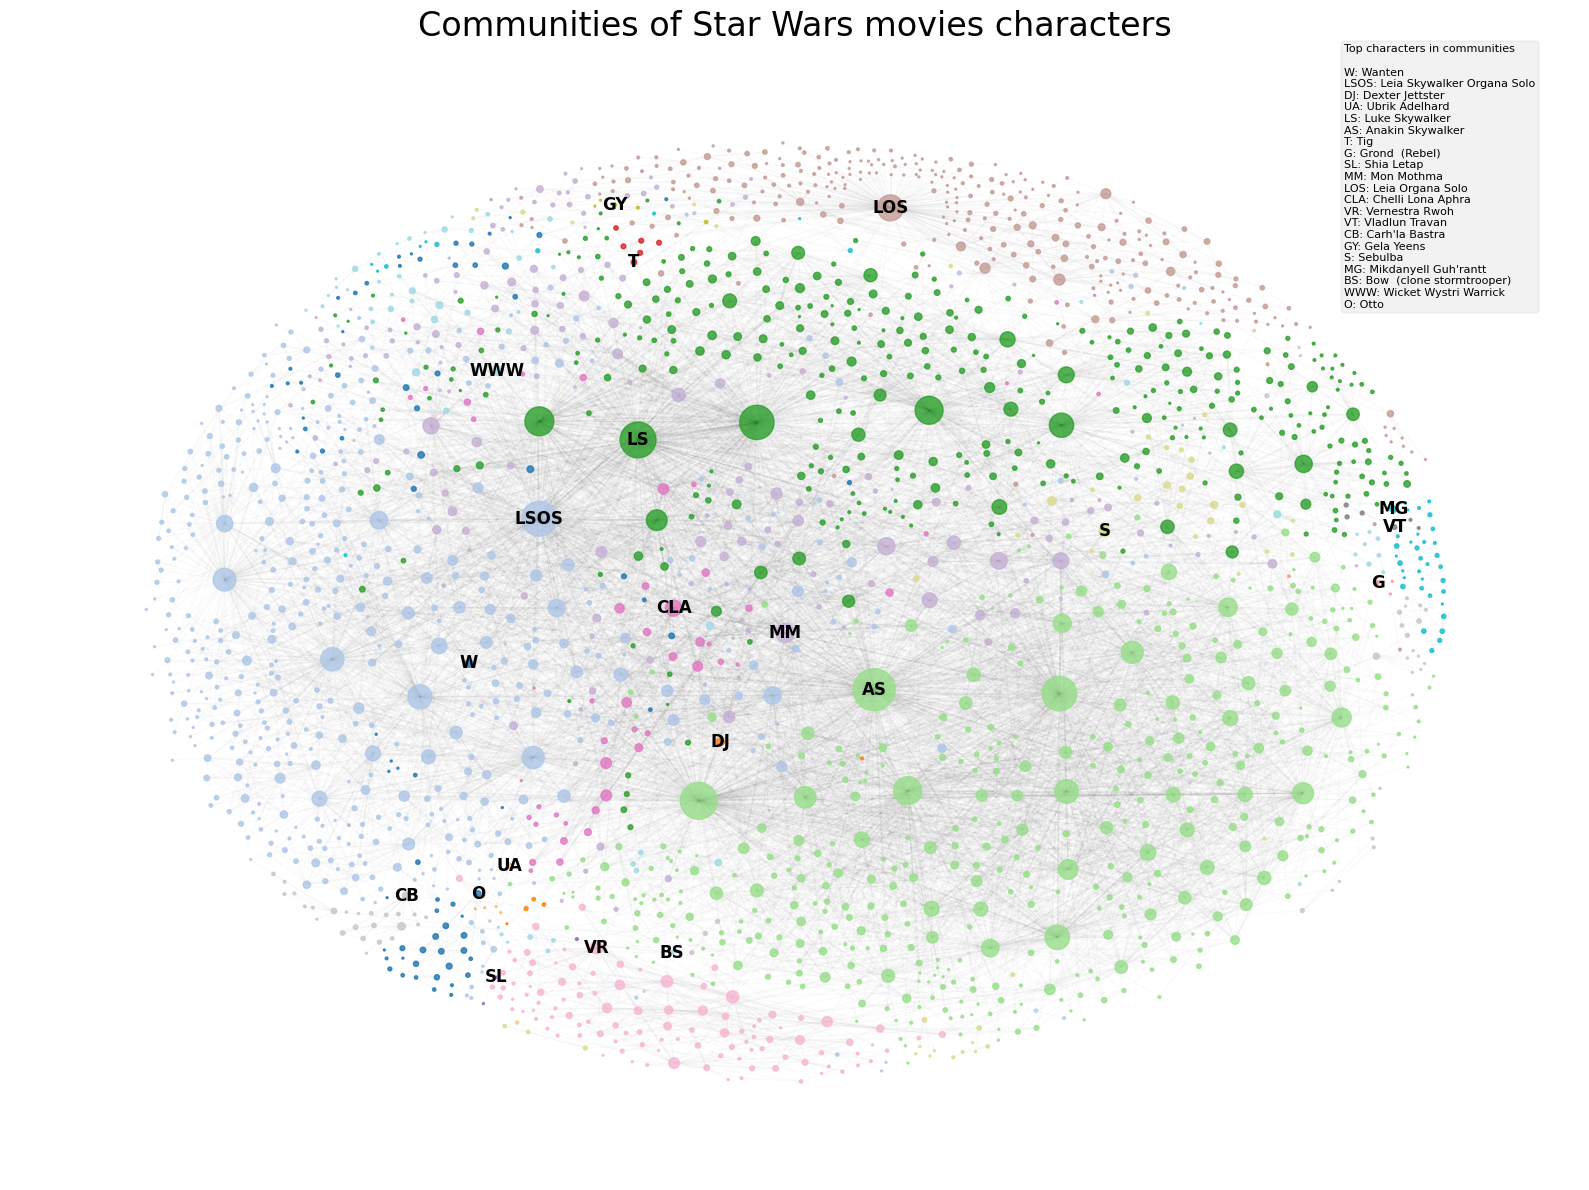

In [53]:
# prepare color map
cmap = cm.get_cmap("tab20", max(partition.values()) + 1)
cmap.N += 1
cmap.colors = np.concatenate((cmap.colors, np.array([colors.to_rgba(style.Color.RASBERRY_RED)])))

ax = graph.plot_graph_with_positons(
    universe_episodes,
    positions,
    "Communities of Star Wars movies characters",
    figsize=(16, 12),
    node_color=list(partition.values()),
    cmap=cmap,
    node_size_factor=2,
    labels=dict(labels),
    edge_alpha=0.02,
    label_font_size=12
)

props = dict(boxstyle="round", facecolor=style.Color.BLACK, alpha=0.05)

text_initials = "\n".join(
    f"{initials}: {mapping[name]}" for (name, initials) in labels
)
text_initials = "Top characters in communities\n\n" + text_initials
ax.text(0.85, 1, text_initials, transform=ax.transAxes, fontsize=8, verticalalignment="top", bbox=props);
plt.show()

Number of nodes per community

In [54]:
for community_no, nodes_no in communities.items():
    print(f"Community {community_no:4d}, nodes: {nodes_no:4d}, largest hub: {mapping[top_characters_in_community[community_no]]}")

Community    0, nodes:   52, largest hub: Wanten
Community    1, nodes:  513, largest hub: Leia Skywalker Organa Solo
Community    4, nodes:  370, largest hub: Luke Skywalker
Community    5, nodes:  439, largest hub: Anakin Skywalker
Community    9, nodes:  175, largest hub: Mon Mothma
Community   10, nodes:  302, largest hub: Leia Organa Solo
Community   12, nodes:  108, largest hub: Vernestra Rwoh
Community   11, nodes:   49, largest hub: Chelli Lona Aphra
Community   16, nodes:   50, largest hub: Sebulba
Community   17, nodes:   46, largest hub: Mikdanyell Guh'rantt
Community   19, nodes:   55, largest hub: Wicket Wystri Warrick
Community   14, nodes:   50, largest hub: Carh'la Bastra
Community   13, nodes:    6, largest hub: Vladlun Travan
Community   15, nodes:    5, largest hub: Gela Yeens
Community   18, nodes:   10, largest hub: Bow  (clone stormtrooper)
Community   20, nodes:   22, largest hub: Otto
Community    2, nodes:    6, largest hub: Dexter Jettster
Community    3, node

### Generate Word Cloud from Term Frequency - Inverse TermFrequency (TFIDF)

In [55]:
# calculate term frequency for characters that occur in Episodes
tokens = (token for text in episodes_characters_data.Content for token in nltk.word_tokenize(text))
tokens = sentiment.SentimentAnalyzer.normalize_text(tokens)

term_freqs = sentiment.term_freq(tokens)

In [56]:
# calculate inverse term freq for all texts
texts = [sentiment.SentimentAnalyzer.normalize_text(nltk.word_tokenize(content)) for content in data.Content]
idf = sentiment.inv_doc_freq(texts)

tfidf = {}
for term, freq in term_freqs.items():
    tfidf[term] = freq * idf.get(term, 1)

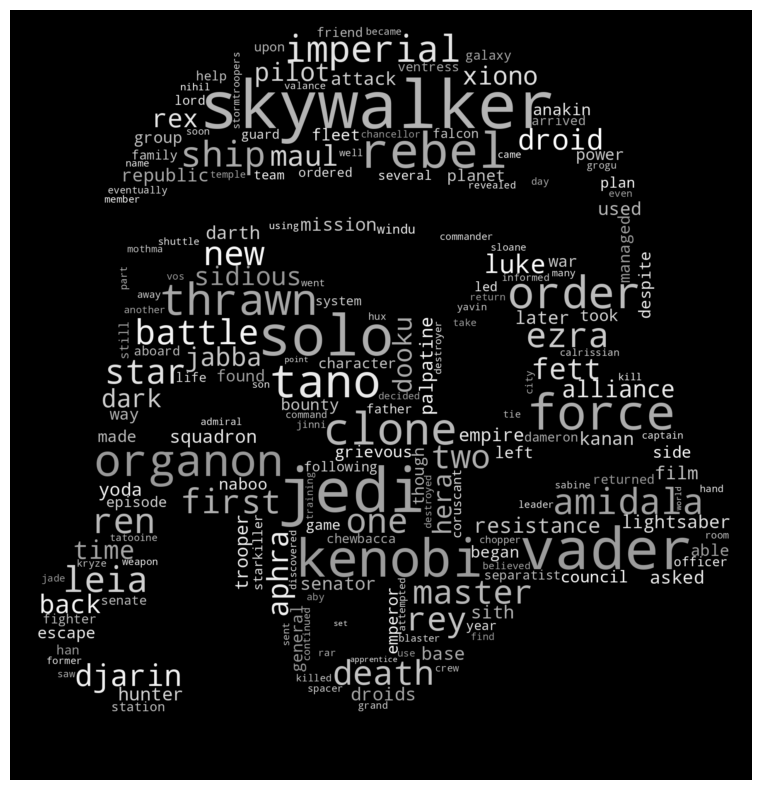

In [59]:
# visualize words in a storm trooper style
mask = 255 - np.array(Image.open("images/stormtrooper.png"))
def _grey_color_func(
    word,
    font_size,
    position,
    orientation,
    random_state=None,
    **kwargs,
):
    return f"hsl(0, 0%, {random.randint(60, 100):d}%)"

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
wordcloud = WordCloud(
    collocations=False,
    background_color="black",
    colormap="inferno",
    height=1024,
    mask=mask,
).generate_from_frequencies(tfidf)

ax.imshow(wordcloud.recolor(color_func=_grey_color_func), interpolation="bilinear")
ax.axis("off")
plt.show()

### Communities for separate movies

Number of characters in movie 1: 366
Number of characters in movie 2: 423
Number of characters in movie 3: 409
Number of characters in movie 4: 1467
Number of characters in movie 5: 372
Number of characters in movie 6: 538


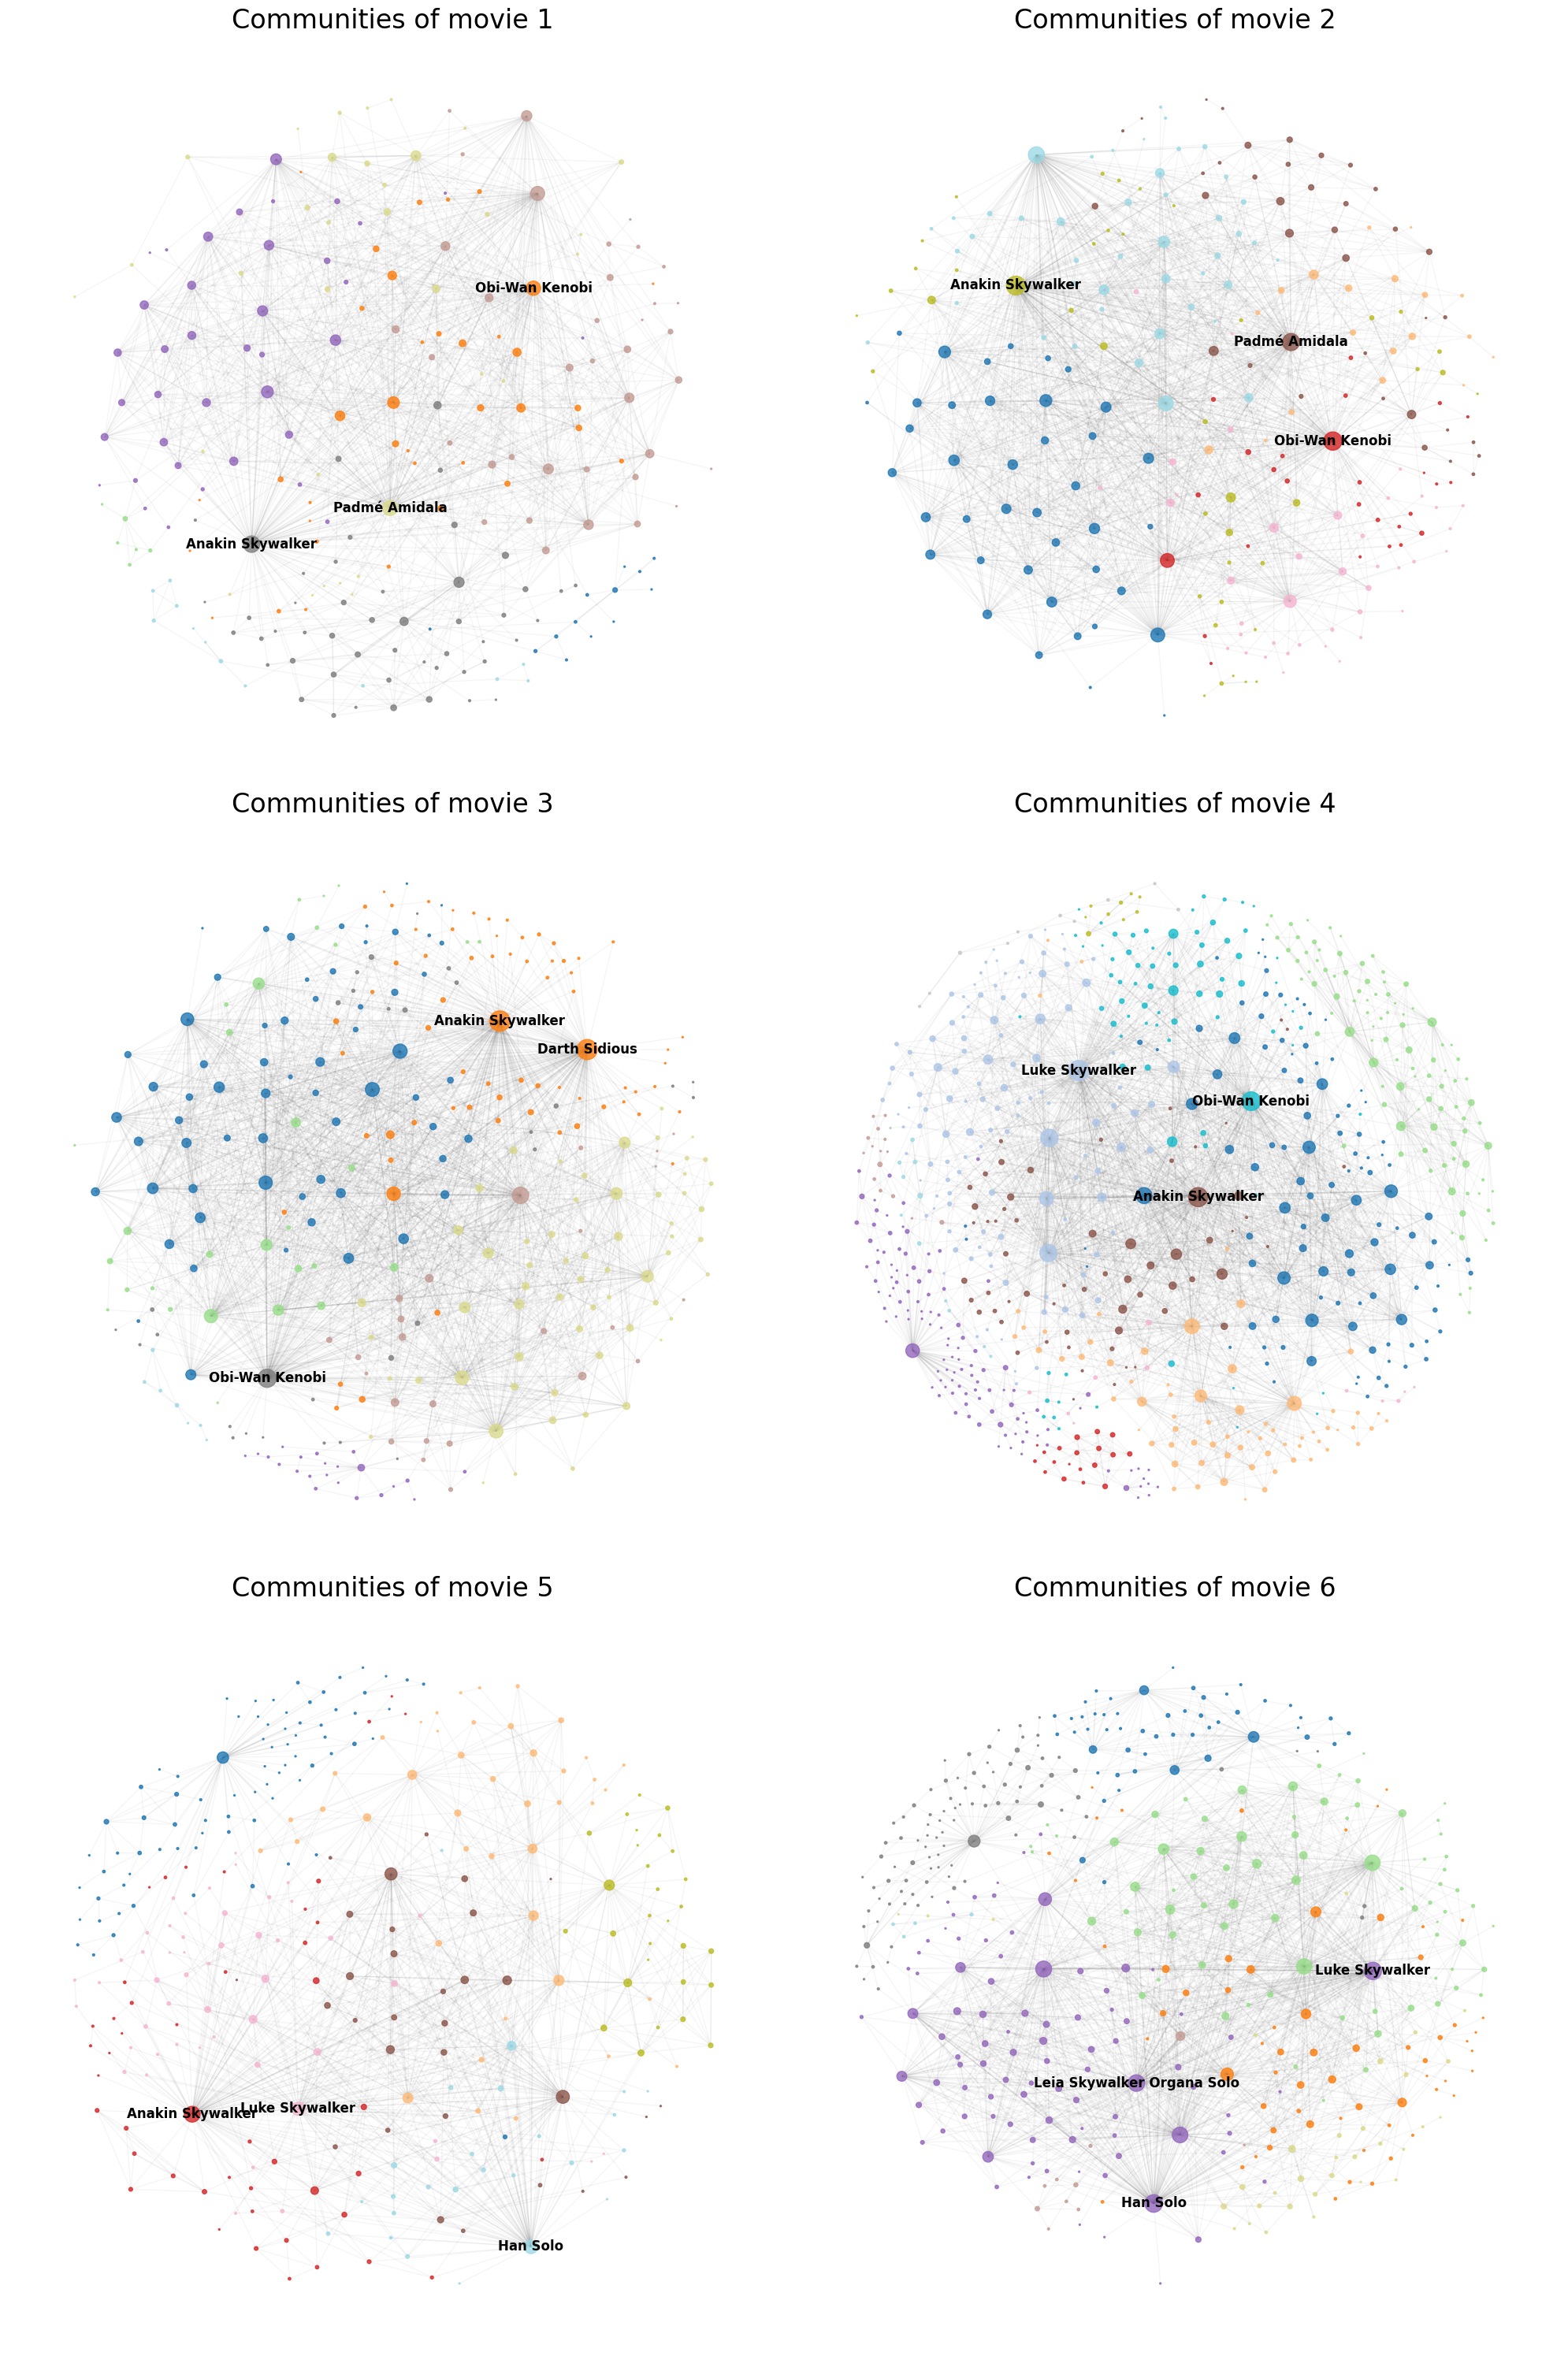

In [60]:
fig, ax = plt.subplots(3,2, figsize = (20,30))

fa_positions_path_tmpl= "graph/fa_positions_ep{}.pickle"
for i in range(6):
    # find characters from matching episode
    characters_in_episodes = datautils.find_rows_with(episodes[i], data, lookup_column="Crosslinks", match_column="Name")
    # filter dataframe with found characters
    episode_data = data.loc[data['Name'].isin(characters_in_episodes)] 

    print(f'Number of characters in movie {i + 1}: {len(episode_data)}')

    # calculate largest connected component
    episode_graph = graph.connected_components(graph.create_directed_graph(episode_data)).to_undirected()

    fa_positions_path = fa_positions_path_tmpl.format(i+1)
    if os.path.exists(fa_positions_path):
        # load positions if they already exist for consistency
        with open(fa_positions_path, "rb") as rbfile:
            positions_episode = pickle.load(rbfile)
    else:
        # calculate graph positions for an undirected graph
        positions_episode = fa2.ForceAtlas2(
            strongGravityMode=True,
            verbose=False
        ).forceatlas2_networkx_layout(episode_graph, pos=None, iterations=2000)
        # save positions for later use
        with open(fa_positions_path, "wb") as wbfile:
            pickle.dump(positions_episode, wbfile)

    # find communities and its properties
    partition, communities, mod = graph.find_communities(episode_graph)
    # use tab20 colormap
    cmap = cm.get_cmap("tab20", max(partition.values()) + 1)
    # add labels for three largest hubs
    node_degrees = sorted(episode_graph.degree, key=lambda x: x[1], reverse=True)
    labels = [(name[0], episode_data[episode_data.Name == name[0]].DisplayName.values[0]) for name in node_degrees[:3]]

    graph.plot_graph_with_positons(
        episode_graph,
        positions_episode,
        f"Communities of movie {i+1}",
        node_color=list(partition.values()),
        cmap=cmap,
        node_size_factor=2,
        edge_alpha=0.04,
        label_font_size=12,
        ax=ax[int(np.floor(i/2)), i%2],
        labels=dict(labels)
        )
plt.show()

## TODO: Sentiment analysis